In [315]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.analysis_helpers import side_by_side_bar_plot, get_value_counts, distribution_plots
from scipy.stats import mannwhitneyu, kruskal, rankdata

pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv("../data/movieReplicationSet.csv")

# Extra Credit

## Working with additional movie attributes

Methodology:

1. Using imdbapi.dev api, get id of each movie using search query
2. Using each movie get movie attributes
3. Perform statistical analysis based on median split of attribute

### Generate Additional Movie Attributes

In [112]:
import requests
import urllib.parse
import time

In [278]:
def get_movie_id(movie):
    # api endpoint
    endpoint = "https://api.imdbapi.dev/search/titles?query=" 

    # Separate movie title from year
    title = movie[:-7]  
    year = movie[-5:-1]

     # Get url for api call
    encoded_movie_title = urllib.parse.quote(title)  # replace special characters with percent-encoded equivalents
    url = endpoint+encoded_movie_title
    

    # Perform GET request
    response = requests.get(url)
    output = response.json()

    # If successful get request  
    if response.status_code == 200:
        output = response.json()  # json response of GET request
        num_matched_movies = 0  # counter for # of movies in response that movie in question matches with. Should only be 1.
        
        # loop through all titles in response to get id of movie
        for record in output["titles"]:
            # Check if type is movie 
            if record["type"] == "movie":
                if record["primaryTitle"].title() == title.title() or record["originalTitle"].title() == title.title():
                    # check if year matches
                    if "startYear" in record:
                        if record["startYear"] == int(year):
                            # only take first matched movie
                            if num_matched_movies == 0:
                                id = record["id"]

                            num_matched_movies += 1
            
        # Print if movie has more than one matched id
        if (num_matched_movies > 1):
            print(f"Found {num_matched_movies} ids for {movie}. Returning first found id.")

        # Print if unable to find movie iD
        if (num_matched_movies == 0):
            print(f"Unable to find ID for {movie}. Returning None")
            id = None
            
    # Failed Get Request
    else:
        print(f"Request for {movie} failed with status code: {response.status_code}")
    
    return id
 

In [276]:
def get_movie_info(id):
    info = {}  # Empty dict to hold movie data

    # GET request url
    endpoint = "https://api.imdbapi.dev/titles/"
    url = endpoint + id

    # Perform GET request
    response = requests.get(url)

    # If successful GET request
    if response.status_code == 200:
        output = response.json()
        info["genres"] = output["genres"]
        info["runtime_seconds"] = output["runtimeSeconds"]
        info["number_of_writers"] = len(output["writers"])
    else:
        print("Unable to find movie information for id: {id}}")
        
    return info

In [394]:
movie_info = []
endpoint = "https://api.imdbapi.dev/search/titles?query="  # Example URL
movies = df.columns[:399]

for movie in movies:
    print(movie)

    # Dictionary to hold movie information
    curr_movie_info = {}
    curr_movie_info["title"] = movie

    # Get id of movie in database
    id = get_movie_id(movie)
    curr_movie_info["id"] = id

    if id is not None:
        # Use id to get movie info
        movie_features = get_movie_info(id)

        if movie_features is not None:
            curr_movie_info.update(get_movie_info(id))
    
    # Append to all movies information dictionary
    movie_info.append(curr_movie_info)
    
    # Sleep for 0.5 seconds to avoid overloading the API with requests and getting an error
    time.sleep(0.5)

The Life of David Gale (2003)
Wing Commander (1999)
Django Unchained (2012)
Alien (1979)
Indiana Jones and the Last Crusade (1989)
Snatch (2000)
Rambo: First Blood Part II (1985)
Fargo (1996)
Let the Right One In (2008)
Black Swan (2010)
King Kong (1976)
The Machinist (2004)
A Nightmare on Elm Street (1984)
Brazil (1985)
The Fast and the Furious (2001)
Change of Habit (1969)
American Beauty (1999)
Psycho (1960)
Terminator 3: Rise of the Machines (2003)
Night of the Living Dead (1968)
Man on Fire (2004)
Star Wars: Episode IV - A New Hope (1977)
The Silence of the Lambs (1991)
The Others (2001)
Minority Report (2002)
Sling Blade (1996)
Schindler's List (1993)
3000 Miles to Graceland (2001)
Magnolia (1999)
The Karate Kid Part II (1986)
Planet of the Apes (2001)
The Godfather: Part II (1974)
Unable to find ID for The Godfather: Part II (1974). Returning None
Indiana Jones and the Temple of Doom (1984)
Indiana Jones and the Raiders of the Lost Ark (1981)
Unable to find ID for Indiana Jones 

In [397]:
# write to csv file
df_movie_info = pd.DataFrame(movie_info)
df_movie_info.to_csv("../data/additional_movie_attributes.csv", index=False)

### Analysis

In [398]:
# Read in data
df_movie_info = pd.read_csv("../data/additional_movie_attributes.csv")
df_surveys = pd.read_csv("../data/movieReplicationSet.csv")

In [399]:
# Filter survey data to just movie columns
movie_columns = df_surveys.columns[:400]
rating_data = df_surveys[movie_columns]

# Rank participants ratings across all columns (ranking of all movies for 1 participant)
ranked_data = rating_data.rank(axis=1, method='average', na_option='keep')
standardized_ranks = ranked_data.div(ranked_data.max(axis=1), axis=0)  # Standardize the ranks to be between 0 and 1 by dividing by maximum ranking
avg_rank = standardized_ranks.mean()  # Get average standardized ranking for each movie

# Convert to pandas dataframe
df_avg_rankings = pd.DataFrame(avg_rank).reset_index()
df_avg_rankings.columns = ["title", "avg_ranking"]

# Merge avg rankings dataframe with additional movie attributes dataframe
df_movie_info = pd.merge(df_movie_info, df_avg_rankings, how="left", on="title")

In [418]:
# Create comparison samples based on median split of movie length
runtime_median = df_movie_info["runtime_seconds"].median()  # Movie length median
short_movie_rankings = df_movie_info.loc[df_movie_info["runtime_seconds"] < runtime_median]["avg_ranking"]
long_movie_rankings = df_movie_info.loc[df_movie_info["runtime_seconds"] >= runtime_median]["avg_ranking"]

# calculate medians for each sample
short_movie_median = round(short_movie_rankings.median(), 2)
long_movie_median = round(long_movie_rankings.median(), 2)

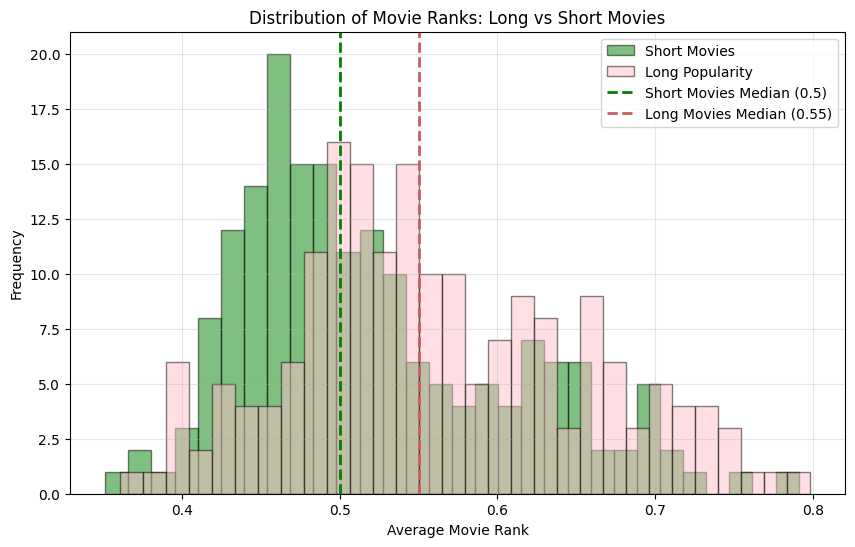

In [420]:
# Plot both samples
plt.figure(figsize=(10, 6))
plt.hist(short_movie_rankings, alpha=0.5, label='Short Movies', bins=30, color='green', edgecolor = 'black')
plt.hist(long_movie_rankings, alpha=0.5, label='Long Popularity', bins=30, color='pink', edgecolor = 'black')
plt.axvline(x=short_movie_median, color='green', linestyle='--', linewidth=2, label=f"Short Movies Median ({short_movie_median})")
plt.axvline(x=long_movie_median, color='indianred', linestyle='--', linewidth=2, label=f"Long Movies Median ({long_movie_median})")

plt.xlabel('Average Movie Rank')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Ranks: Long vs Short Movies')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [393]:
U, p = mannwhitneyu(long_movie_rankings, short_movie_rankings, alternative='greater')
print(f"U-statistic: {U}")
print(f"p-value: {p}")

U-statistic: 21750.0
p-value: 1.1355299988086742e-06


In [422]:
# Number of movies that we could not get additional attributes for
pd.isnull(df_movie_info["number_of_writers"]).sum()

np.int64(32)

In [423]:
df_movie_info

,title,id,genres,runtime_seconds,number_of_writers,avg_ranking
0,The Life of David Gale (2003),tt0289992,"['Crime', 'Drama', 'Mystery', 'Thriller']",7800.0,1.0,0.483883
1,Wing Commander (1999),tt0131646,"['Action', 'Adventure', 'Sci-Fi']",6000.0,2.0,0.445357
2,Django Unchained (2012),tt1853728,"['Drama', 'Western']",9900.0,1.0,0.674634
3,Alien (1979),tt0078748,"['Horror', 'Sci-Fi']",7020.0,2.0,0.530854
4,Indiana Jones and the Last Crusade (1989),tt0097576,"['Action', 'Adventure']",7620.0,3.0,0.505669
5,Snatch (2000),tt0208092,"['Comedy', 'Crime']",6120.0,1.0,0.521144
6,Rambo: First Blood Part II (1985),tt0089880,"['Action', 'Adventure', 'Thriller']",5760.0,3.0,0.429844
7,Fargo (1996),tt0116282,"['Crime', 'Drama', 'Thriller']",5880.0,2.0,0.616529
8,Let the Right One In (2008),tt1139797,"['Drama', 'Fantasy', 'Horror', 'Romance']",6840.0,1.0,0.485860
9,Black Swan (2010),tt0947798,"['Drama', 'Thriller']",6480.0,3.0,0.582338
